In [1]:
from PDR.modules.DataLoader import *
from PDR.modules.Walker import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
file_name = "cc"
pvloader = DataLoader("PDR/data/200610.db", file_name)
pvloader.DBLoader()
sensor_df = pvloader.sensor_df[["time", "accx", "accy", "accz", "gyrox", "gyroy",
                                "gyroz", "rot0", "rot1", "rot2", "rot3", "game0", "game1", "game2", "game3"]]
print(sensor_df)

Data parsing... 
Data parsing done!
               time      accx      accy       accz     gyrox     gyroy  \
0     1591773699770 -0.146040  5.863148   8.350616 -0.047216  0.110345   
1     1591773699790 -0.076611  5.968488   7.900526  0.037083 -0.278165   
2     1591773699810 -0.098158  5.867936   7.651539  0.013260 -0.213413   
3     1591773699830  0.083793  5.810478   7.574928 -0.060044  0.007720   
4     1591773699850  0.160405  5.793719   7.799973 -0.085090  0.004665   
...             ...       ...       ...        ...       ...       ...   
5515  1591773810071  0.277715  3.028535   9.143063 -0.019727 -0.101014   
5516  1591773810091  0.342356  3.045294   8.810283  0.046857 -0.082077   
5517  1591773810111  0.246592  3.102752   8.429622 -0.090587  0.023602   
5518  1591773810131  0.007182  2.971076   9.217280 -0.285453  0.282609   
5519  1591773810151 -0.043094  3.157816  10.392783 -0.251245  0.313763   

         gyroz      rot0      rot1      rot2      rot3     game0     game1 

In [3]:
walker = Walker()
for row in sensor_df.itertuples():
    if row[0] % 1000 == 0:
        print("step is " + str(row[0]))
    walker.step(row[0], row[1], row[2:5], row[5:8], row[8:12], row[12:16])


step is 0
step is 1000
step is 2000
step is 3000
step is 4000
step is 5000


In [4]:

displacement_df = pdr_to_displacement(walker.pdr_df)
position_df = displacement_df.cumsum()

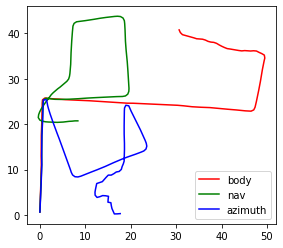

In [5]:
fig, ax = plt.subplots()
ax.plot(position_df['body_x'],
        position_df['body_y'], label="body", c='r')
ax.plot(position_df['nav_x'],
        position_df['nav_y'], label="nav", c='g')
ax.plot(position_df['azimuth_x'],
        position_df['azimuth_y'], label="azimuth", c='b')
ax.legend(loc='best')
ax.set_aspect('equal')

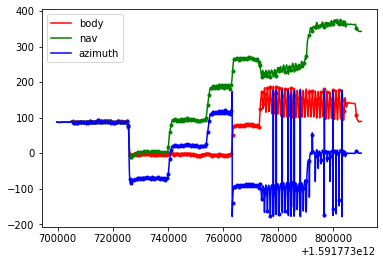

In [6]:
fig2, ax2 = plt.subplots()
ax2.plot(walker.headingcalc.heading_df['time'],
            np.rad2deg(walker.headingcalc.heading_df['body']), label="body", c='r')
ax2.plot(walker.headingcalc.heading_df['time'],
            np.rad2deg(walker.headingcalc.heading_df['nav']), label="nav", c='g')
ax2.plot(walker.headingcalc.heading_df['time'],
            np.rad2deg(walker.headingcalc.heading_df['azimuth']), label="azimuth", c='b')
peak_index = walker.pvdetect.peak_df["idx"]
ax2.scatter(walker.headingcalc.heading_df['time'].loc[peak_index],
            np.rad2deg(walker.headingcalc.heading_df['body'].loc[peak_index]), marker='.', c='r')
ax2.scatter(walker.headingcalc.heading_df['time'].loc[peak_index],
            np.rad2deg(walker.headingcalc.heading_df['nav'].loc[peak_index]), marker='.', c='g')
ax2.scatter(walker.headingcalc.heading_df['time'].loc[peak_index],
            np.rad2deg(walker.headingcalc.heading_df['azimuth'].loc[peak_index]), marker='.', c='b')
ax2.legend(loc='best')